In [3]:
from google.colab import files
uploaded = files.upload()


Saving nbaiot_combined.csv to nbaiot_combined.csv


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os

In [5]:
if not os.path.exists("nbaiot_combined.csv"):
    df_benign = pd.read_csv('1.benign.csv')
    df_attack = pd.read_csv('1.mirai.scan.csv')
    df_benign['label'] = 0
    df_attack['label'] = 1
    df_combined = pd.concat([df_benign, df_attack], ignore_index=True)
    df_combined.to_csv('nbaiot_combined.csv', index=False)

In [6]:
data_path = "nbaiot_combined.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f" Le fichier {data_path} est introuvable.")

df = pd.read_csv(data_path)

if 'label' not in df.columns:
    raise ValueError(" Le fichier CSV doit contenir une colonne 'label' pour la classe cible.")

X = df.drop('label', axis=1)
y = df['label']

In [7]:
X = X.apply(pd.to_numeric, errors='coerce')
X.fillna(0, inplace=True)

In [8]:
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC()
}


Logistic Regression - F1 Score: 0.9999


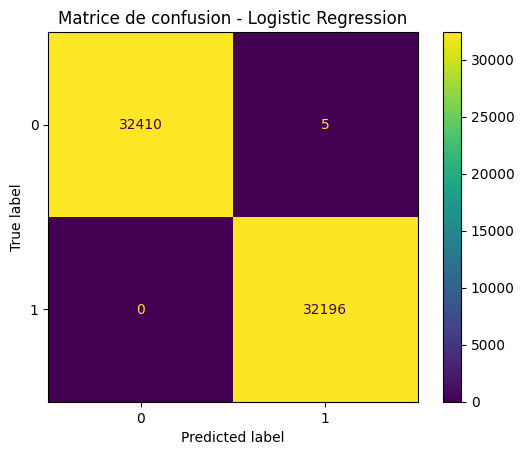


Random Forest - F1 Score: 1.0000


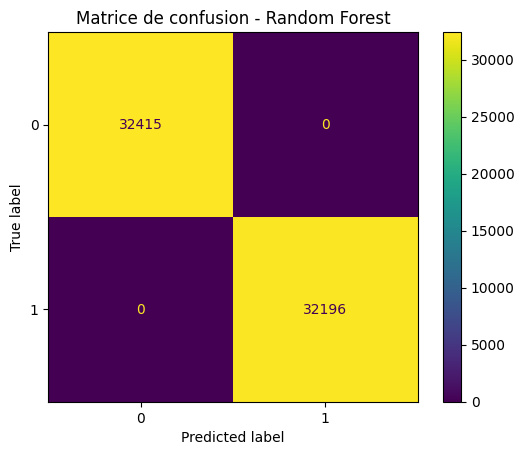


SVM - F1 Score: 0.9999


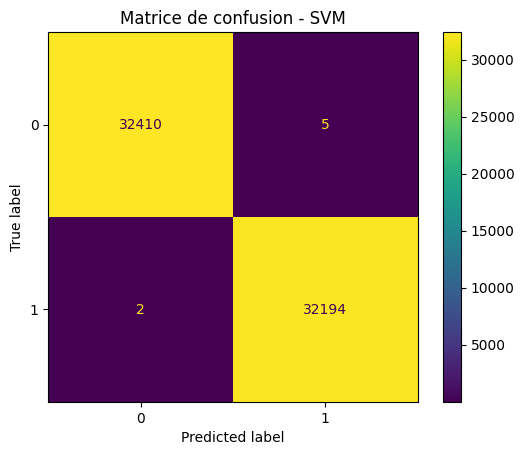

In [12]:
f1_scores = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='binary')
    f1_scores[name] = f1
    print(f"\n{name} - F1 Score: {f1:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Matrice de confusion - {name}")
    plt.savefig(f"matrice_confusion_{name.replace(' ', '_')}.png")
    plt.show()

In [13]:
best_model_name = max(f1_scores, key=f1_scores.get)
print(f"\n Meilleur modèle : {best_model_name}")


 Meilleur modèle : Random Forest


In [14]:
if best_model_name == "Random Forest":
    param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
    grid = GridSearchCV(RandomForestClassifier(), param_grid, scoring='f1', cv=5)
elif best_model_name == "SVM":
    param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
    grid = GridSearchCV(SVC(), param_grid, scoring='f1', cv=5)
elif best_model_name == "Logistic Regression":
    param_grid = {'C': [0.01, 0.1, 1, 10]}
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, scoring='f1', cv=5)

grid.fit(X_train, y_train)
print("\n Meilleurs hyperparamètres trouvés :", grid.best_params_)
best_model = grid.best_estimator_


 Meilleurs hyperparamètres trouvés : {'max_depth': None, 'n_estimators': 100}


Nouveau F1 Score après optimisation : 1.0000


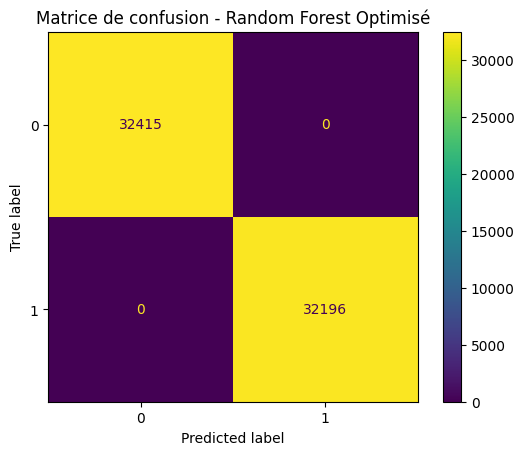

In [15]:
y_pred_optimized = best_model.predict(X_test)
f1_optimized = f1_score(y_test, y_pred_optimized, average='binary')
print(f"Nouveau F1 Score après optimisation : {f1_optimized:.4f}")
cm_opt = confusion_matrix(y_test, y_pred_optimized)
ConfusionMatrixDisplay(confusion_matrix=cm_opt).plot()
plt.title(f"Matrice de confusion - {best_model_name} Optimisé")
plt.savefig(f"matrice_confusion_{best_model_name.replace(' ', '_')}_optimise.png")
plt.show()

In [16]:
print("\n Résumé des F1 Scores avant optimisation :")
for name, score in f1_scores.items():
    print(f"- {name}: {score:.4f}")
print(f"\n Modèle final retenu : {best_model_name} avec F1 optimisé de {f1_optimized:.4f}")

with open("resultats_f1.txt", "w") as f:
    f.write(" Résumé des F1 Scores avant optimisation :\n")
    for name, score in f1_scores.items():
        f.write(f"- {name}: {score:.4f}\n")
    f.write(f"\n Modèle final retenu : {best_model_name} avec F1 optimisé de {f1_optimized:.4f}\n")


 Résumé des F1 Scores avant optimisation :
- Logistic Regression: 0.9999
- Random Forest: 1.0000
- SVM: 0.9999

 Modèle final retenu : Random Forest avec F1 optimisé de 1.0000
